## Description

Weight Matrix construction including pseudo counts and sequence weighting

Some parts of the code have been blanked out. Fill out these places to make the code run. 

## Python Imports

In [125]:
import numpy as np
import math
import copy
from pprint import pprint

%matplotlib inline

## DEFINE THE PATH TO YOUR COURSE DATA DIRECTORY

In [126]:
data_dir = "../../data/"

## Define options for run

In [127]:
sequence_weighting = False
#sequence_weighting = False
# define weight on pseudo count
beta = 0

## Data Imports

### Load Alphabet

In [128]:
alphabet_file = data_dir + "Matrices/alphabet"

alphabet = np.loadtxt(alphabet_file, dtype=str)

print (alphabet)
print (len(alphabet))

['A' 'R' 'N' 'D' 'C' 'Q' 'E' 'G' 'H' 'I' 'L' 'K' 'M' 'F' 'P' 'S' 'T' 'W'
 'Y' 'V']
20


### Load Background Frequencies

In [129]:
bg_file = data_dir + "Matrices/bg.freq.fmt"
_bg = np.loadtxt(bg_file, dtype=float)

bg = {}
for i in range(0, len(alphabet)):
    bg[alphabet[i]] = _bg[i]

bg

{'A': 0.074,
 'R': 0.052,
 'N': 0.045,
 'D': 0.054,
 'C': 0.025,
 'Q': 0.034,
 'E': 0.054,
 'G': 0.074,
 'H': 0.026,
 'I': 0.068,
 'L': 0.099,
 'K': 0.058,
 'M': 0.025,
 'F': 0.047,
 'P': 0.039,
 'S': 0.057,
 'T': 0.051,
 'W': 0.013,
 'Y': 0.032,
 'V': 0.073}

### Load Blosum62 Matrix


In [130]:
blosum62_file = data_dir + "Matrices/blosum62.freq_rownorm"
_blosum62 = np.loadtxt(blosum62_file, dtype=float).T

blosum62 = {}

for i, letter_1 in enumerate(alphabet):
    
    blosum62[letter_1] = {}

    for j, letter_2 in enumerate(alphabet):
        
        blosum62[letter_1][letter_2] = _blosum62[i, j]

blosum62

{'A': {'A': 0.2901,
  'R': 0.0446,
  'N': 0.0427,
  'D': 0.041,
  'C': 0.065,
  'Q': 0.0559,
  'E': 0.0552,
  'G': 0.0783,
  'H': 0.042,
  'I': 0.0471,
  'L': 0.0445,
  'K': 0.057,
  'M': 0.0522,
  'F': 0.0338,
  'P': 0.0568,
  'S': 0.1099,
  'T': 0.073,
  'W': 0.0303,
  'Y': 0.0405,
  'V': 0.07},
 'R': {'A': 0.031,
  'R': 0.345,
  'N': 0.0449,
  'D': 0.0299,
  'C': 0.0163,
  'Q': 0.0735,
  'E': 0.0497,
  'G': 0.0229,
  'H': 0.0458,
  'I': 0.0177,
  'L': 0.0243,
  'K': 0.1071,
  'M': 0.0321,
  'F': 0.019,
  'P': 0.0258,
  'S': 0.0401,
  'T': 0.0355,
  'W': 0.0227,
  'Y': 0.028,
  'V': 0.0219},
 'N': {'A': 0.0256,
  'R': 0.0388,
  'N': 0.3169,
  'D': 0.069,
  'C': 0.0163,
  'Q': 0.0441,
  'E': 0.0405,
  'G': 0.0391,
  'H': 0.0534,
  'I': 0.0147,
  'L': 0.0142,
  'K': 0.0415,
  'M': 0.0201,
  'F': 0.0169,
  'P': 0.0233,
  'S': 0.0541,
  'T': 0.0434,
  'W': 0.0152,
  'Y': 0.0218,
  'V': 0.0165},
 'D': {'A': 0.0297,
  'R': 0.031,
  'N': 0.0831,
  'D': 0.3974,
  'C': 0.0163,
  'Q': 0.0471,


### Load Peptides

In [148]:
peptides_file = data_dir + "PSSM/A0201.single_lig"
#peptides_file = data_dir + "PSSM/A0201.small_lig"
#peptides_file = data_dir + "PSSM/A0201.large_lig"

peptides = np.loadtxt(peptides_file, dtype=str).tolist()

if len(peptides[0]) == 1:
    peptide_length = len(peptides)
    peptides = [peptides]
else:
    peptide_length = len(peptides[0])

for i in range(0, len(peptides)):
    if len(peptides[i]) != peptide_length:
        print("Error, peptides differ in length!")
        
print(peptides)
peptide_length

['ALAKAAAAM']


9

## Initialize Matrix

In [132]:
def initialize_matrix(peptide_length, alphabet):

    init_matrix = [0]*peptide_length

    for i in range(0, peptide_length):

        row = {}

        for letter in alphabet: 
            row[letter] = 0.0

        #fancy way:  row = dict( zip( alphabet, [0.0]*len(alphabet) ) )

        init_matrix[i] = row
        
    return init_matrix

## Amino Acid Count Matrix (c)

In [133]:
c_matrix = initialize_matrix(peptide_length, alphabet)

for position in range(0, peptide_length):
        
    for peptide in peptides:
        
        c_matrix[position][peptide[position]] += 1
    
#pprint(c_matrix)
c_matrix[0]["A"]

6.0

## Sequence Weighting

In [134]:
# w = 1 / r * s
# where 
# r = number of different amino acids in column
# s = number of occurrence of amino acid in column

weights = {}

for peptide in peptides:

    # apply sequence weighting
    if sequence_weighting:
    
        w = 0.0
        neff = 0.0
        
        for position in range(0, peptide_length):

            r = 0

            for letter in alphabet:        

                if c_matrix[position][letter] != 0:
                    
                    r += 1

            s = c_matrix[position][peptide[position]]

            w += 1.0/(r * s)

            neff += r
                
        neff = neff / peptide_length
  
    # do not apply sequence weighting
    else:
        
        w = 1  
        
        neff = len(peptides)  
      

    weights[peptide] = w

pprint( "W:")
pprint( weights )
pprint( "Nseq:")
pprint( neff )

'W:'
{'ALAKAAAAM': 1,
 'ALAKAAAAN': 1,
 'ALAKAAAAR': 1,
 'ALAKAAAAT': 1,
 'ALAKAAAAV': 1,
 'AVVPFIVSV': 1,
 'GILGFVFTM': 1,
 'GMNERPILT': 1,
 'KLNEPVLLL': 1,
 'TLNAWVKVV': 1}
'Nseq:'
10


## Observed Frequencies Matrix (f)

In [135]:
f_matrix = initialize_matrix(peptide_length, alphabet)

for position in range(0, peptide_length):
  
    n = 0;
  
    for peptide in peptides:
    
        f_matrix[position][peptide[position]] += weights[peptide]
    
        n += weights[peptide]
        
    for letter in alphabet: 
        
        f_matrix[position][letter] = f_matrix[position][letter]/n
      
pprint( f_matrix[0] )

{'A': 0.6,
 'C': 0.0,
 'D': 0.0,
 'E': 0.0,
 'F': 0.0,
 'G': 0.2,
 'H': 0.0,
 'I': 0.0,
 'K': 0.1,
 'L': 0.0,
 'M': 0.0,
 'N': 0.0,
 'P': 0.0,
 'Q': 0.0,
 'R': 0.0,
 'S': 0.0,
 'T': 0.1,
 'V': 0.0,
 'W': 0.0,
 'Y': 0.0}


## Pseudo Frequencies Matrix (g)

Remember g(b) = sum f(a)* q(b|a), and blosum[a,b] = q(a|b)

In [136]:
g_matrix = initialize_matrix(peptide_length, alphabet)

for position in range(0, peptide_length):

    for letter_1 in alphabet:
        for letter_2 in alphabet:
        
          g_matrix[position][letter_1] += f_matrix[position][letter_2] * blosum62[letter_1][letter_2]

pprint(g_matrix[0])

{'A': 0.20272000000000004,
 'C': 0.01776,
 'D': 0.03246,
 'E': 0.04044,
 'F': 0.02012,
 'G': 0.15766,
 'H': 0.015030000000000002,
 'I': 0.037790000000000004,
 'K': 0.06579,
 'L': 0.052129999999999996,
 'M': 0.0159,
 'N': 0.031670000000000004,
 'P': 0.02712,
 'Q': 0.027250000000000003,
 'R': 0.03744,
 'S': 0.07588,
 'T': 0.0645,
 'V': 0.05652,
 'W': 0.00543,
 'Y': 0.01617}


## Combined Frequencies Matrix (p)

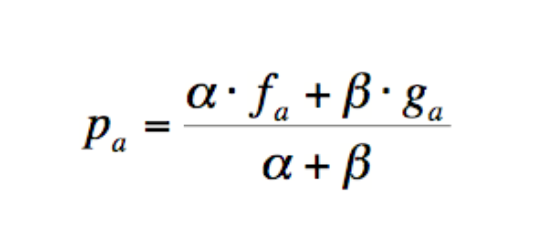

In [137]:
p_matrix = initialize_matrix(peptide_length, alphabet)

alpha = neff - 1

for position in range(0, peptide_length):

    for a in alphabet:
        p_matrix[position][a] = (alpha * f_matrix[position][a] + beta * g_matrix[position][a])/(alpha + beta)

pprint(p_matrix[0])

{'A': 0.6,
 'C': 0.0,
 'D': 0.0,
 'E': 0.0,
 'F': 0.0,
 'G': 0.2,
 'H': 0.0,
 'I': 0.0,
 'K': 0.1,
 'L': 0.0,
 'M': 0.0,
 'N': 0.0,
 'P': 0.0,
 'Q': 0.0,
 'R': 0.0,
 'S': 0.0,
 'T': 0.1,
 'V': 0.0,
 'W': 0.0,
 'Y': 0.0}


## Log Odds Weight Matrix (w)

In [138]:
w_matrix = initialize_matrix(peptide_length, alphabet)

for position in range(0, peptide_length):
    
    for letter in alphabet:
        if p_matrix[position][letter] > 0:
            w_matrix[position][letter] = 2 * math.log(p_matrix[position][letter]/bg[letter])/math.log(2)
        else:
            w_matrix[position][letter] = -999.9

pprint(w_matrix[0])

{'A': 6.038730649733862,
 'C': -999.9,
 'D': -999.9,
 'E': -999.9,
 'F': -999.9,
 'G': 2.8688056482915503,
 'H': -999.9,
 'I': -999.9,
 'K': 1.5717503892943054,
 'L': -999.9,
 'M': -999.9,
 'N': -999.9,
 'P': -999.9,
 'Q': -999.9,
 'R': -999.9,
 'S': -999.9,
 'T': 1.9428616956064584,
 'V': -999.9,
 'W': -999.9,
 'Y': -999.9}


### Write Matrix to PSI-BLAST format

In [139]:
def to_psi_blast(matrix):

    header = ["", "A", "R", "N", "D", "C", "Q", "E", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

    print ('{:>4} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8}'.format(*header)) 

    letter_order = ["A", "R", "N", "D", "C", "Q", "E", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

    for i, row in enumerate(matrix):

        scores = []

        scores.append(str(i+1) + " A")

        for letter in letter_order:

            score = row[letter]

            scores.append(round(score, 4))

        print('{:>4} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8}'.format(*scores)) 

### convert w_matrix to PSI-BLAST format and print to file

In [140]:
def to_psi_blast_file(matrix, file_name):
    
    with open(file_name, 'w') as file:

        header = ["", "A", "R", "N", "D", "C", "Q", "E", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

        file.write ('{:>4} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8}\n'.format(*header)) 

        letter_order = ["A", "R", "N", "D", "C", "Q", "E", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

        for i, row in enumerate(matrix):

            scores = []

            scores.append(str(i+1) + " A")

            for letter in letter_order:

                score = row[letter]

                scores.append(round(score, 4))

            file.write('{:>4} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8}\n'.format(*scores)) 

### convert  w_matrix to PSI-BLAST format

In [141]:
to_psi_blast(w_matrix)

            A        R        N        D        C        Q        E        G        H        I        L        K        M        F        P        S        T        W        Y        V
 1 A   6.0387   -999.9   -999.9   -999.9   -999.9   -999.9   -999.9   2.8688   -999.9   -999.9   -999.9   1.5718   -999.9   -999.9   -999.9   -999.9   1.9429   -999.9   -999.9   -999.9
 2 A   -999.9   -999.9   -999.9   -999.9   -999.9   -999.9   -999.9   -999.9   -999.9   1.1128   5.6437   -999.9      4.0   -999.9   -999.9   -999.9   -999.9   -999.9   -999.9   0.9081
 3 A   5.5127   -999.9   5.4739   -999.9   -999.9   -999.9   -999.9   -999.9   -999.9   -999.9    0.029   -999.9   -999.9   -999.9   -999.9   -999.9   -999.9   -999.9   -999.9   0.9081
 4 A   0.8688   -999.9   -999.9   -999.9   -999.9   -999.9   3.7779   0.8688   -999.9   -999.9   -999.9   6.2156   -999.9   -999.9   2.7169   -999.9   -999.9   -999.9   -999.9   -999.9
 5 A   5.5127   1.8868   -999.9   -999.9   -999.9   -999.9   -999.9   -999.

### convert w_matrix to PSI-BLAST format and print to file

In [142]:
# Write out PSSM in Psi-Blast format to file
file_name = "w_matrix_test"
to_psi_blast_file(w_matrix, file_name)

## Evaluation

In [143]:
#evaluation_file = "https://raw.githubusercontent.com/brunoalvarez89/data/master/algorithms_in_bioinformatics/part_2/A0201.eval"
evaluation_file = data_dir + "PSSM/A0201.eval"
#evaluation_file = evaluation_upload.values()

evaluation = np.loadtxt(evaluation_file, dtype=str).reshape(-1,2)
evaluation_peptides = evaluation[:, 0]
evaluation_targets = evaluation[:, 1].astype(float)

evaluation_peptides, evaluation_targets

(array(['ILYQVPFSV', 'VVMGTLVAL', 'ILDEAYVMA', ..., 'FARGVVHVI',
        'LQRELTRLQ', 'AVAEEMTKS'], dtype='<U9'),
 array([0.8532, 0.5891, 0.4941, ..., 0.    , 0.    , 0.    ]))

In [144]:
def score_peptide(peptide, matrix):
    acum = 0
    for i in range(0, len(peptide)):
        acum += matrix[i][peptide[i]]
    return acum

In [145]:
evaluation_predictions = []
for evaluation_peptide in evaluation_peptides:
    evaluation_predictions.append(score_peptide(evaluation_peptide, w_matrix))

PCC:  0.35427920006019004


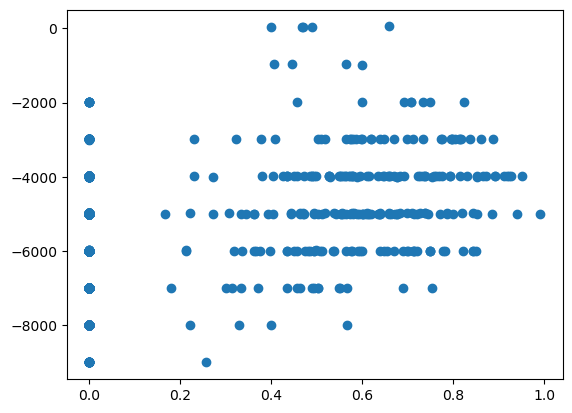

In [146]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

pcc = pearsonr(evaluation_targets, evaluation_predictions)
print("PCC: ", pcc[0])

plt.scatter(evaluation_targets, evaluation_predictions);